# Introduction to sentiment analysis with NLI

In this notebook, you will implement a sentiment scoring pipeline using a Natural Language Inference (NLI) model. 
You will analyze whether news headlines about S&P 500 companies have positive or negative sentiment and explore how this sentiment correlates with market returns.


## Install and Import librairies
Install necessary packages and import the required libraries for:
- Loading data
- Using transformer models
- Plotting and visualizing results
- Downloading financial data

In [2]:
%pip install hf_xet
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import math
import matplotlib.pyplot as plt
import yfinance as yf

## Load news data
Load two datasets:
- `df_news.csv`: contains headlines and summaries
- `df_metadata.csv`: contains ticker symbols and company sector info

We drop duplicate summaries to avoid redundant sentiment scoring.

In [4]:
df_news = pd.read_csv('df_news.csv')
df_news.drop_duplicates('SUMMARY', inplace=True)
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23 10:30:00+00:00,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22 17:49:43+00:00,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21 18:14:38+00:00,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21 16:00:08+00:00,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


In [5]:
df_meta = pd.read_csv('df_metadata.csv')
display(df_meta)

,TICKER,COMPANY_NAME,SECTOR,INDUSTRY
0,MMM,3M Company,Industrials,Conglomerates
1,AOS,A. O. Smith Corporation,Industrials,Specialty Industrial Machinery
2,ABT,Abbott Laboratories,Healthcare,Medical Devices
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,ACN,Accenture plc,Technology,Information Technology Services
...,...,...,...,...
485,XEL,Xcel Energy Inc.,Utilities,Utilities - Regulated Electric
486,XYL,Xylem Inc.,Industrials,Specialty Industrial Machinery
487,YUM,"Yum! Brands, Inc.",Consumer Cyclical,Restaurants
488,ZBH,"Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices


## Sentiment Analysis with NLI

In this section, you will apply a CrossEncoder NLI model (`cross-encoder/nli-deberta-v3-base`) to estimate sentiment from news headlines.

👉 **Instructions**:

1. Use a CrossEncoder NLI model to compute how much a news headline implies a **positive** or **negative** sentiment.
2. For each news title, compute the probability of it being **positive** and **negative**, and store them in `POSITIVE_PROB` and `NEGATIVE_PROB`.
3. Derive a final sentiment score by subtracting: `SENTIMENT = POSITIVE_PROB - NEGATIVE_PROB`.

✅ This score will serve as your sentiment signal, ranging from negative to positive.

> ℹ️ You are free to decide how to structure the input pairs and how to apply the model.


In [6]:
#LOAD THE NLI MODEL

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained("cross-encoder/nli-deberta-v3-base")
model = AutoModelForSequenceClassification.from_pretrained("cross-encoder/nli-deberta-v3-base")

In [7]:
def get_sentiment_probs(premise):
    """
    Use NLI model to get the probability that the premise (headline) implies a positive or negative sentiment.
    """
    hypotheses = ["This text is positive.", "This text is negative."]

    positive_input = tokenizer(premise, hypotheses[0], return_tensors="pt", truncation=True)
    negative_input = tokenizer(premise, hypotheses[1], return_tensors="pt", truncation=True)

    with torch.no_grad():
        pos_logits = model(**positive_input).logits
        neg_logits = model(**negative_input).logits

    pos_entail_prob = F.softmax(pos_logits, dim=1)[0][2].item()
    neg_entail_prob = F.softmax(neg_logits, dim=1)[0][2].item()

    return pos_entail_prob, neg_entail_prob

In [8]:
# SENTIMENT SCORING
positive_probs = []
negative_probs = []

for text in df_news['SUMMARY']:
    pos_prob, neg_prob = get_sentiment_probs(text)
    positive_probs.append(pos_prob)
    negative_probs.append(neg_prob)

df_news['POSITIVE_PROB'] = positive_probs
df_news['NEGATIVE_PROB'] = negative_probs
df_news['SENTIMENT'] = df_news['POSITIVE_PROB'] - df_news['NEGATIVE_PROB']

display(df_news[['SUMMARY', 'POSITIVE_PROB', 'NEGATIVE_PROB', 'SENTIMENT']])

,SUMMARY,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,The Dow Jones (^DJI) is made up of 30 of the m...,0.997744,0.997495,0.000250
1,The S&P 500 (^GSPC) is often seen as a benchma...,0.997495,0.997865,-0.000370
2,"MMM is making strides in the aerospace, indust...",0.006563,0.496011,-0.489448
3,Quarterly earnings results are a good time to ...,0.999482,0.995007,0.004475
4,While strong cash flow is a key indicator of s...,0.990589,0.996618,-0.006030
...,...,...,...,...
4866,Zoetis is a leading animal health company with...,0.112613,0.004976,0.107637
4867,Zoetis (NYSE:ZTS) recently affirmed a dividend...,0.009250,0.005285,0.003965
4868,We recently published a list of Jim Cramer Tal...,0.999479,0.998722,0.000758
4869,Zoetis (ZTS) might move higher on growing opti...,0.007786,0.000230,0.007556


## Compare Sentiment with Returns

In this section, you'll explore how daily news sentiment aligns with market behavior.

👉 **Instructions**:

1. Group the news data by **publication date** and compute the **average sentiment per day**.
2. Download **daily stock prices** for the relevant tickers using `yfinance`.
3. Compute **daily returns** and use their average as a proxy for the market (e.g., S\&P 500).
4. Visualize both **daily sentiment** and **daily returns** over time using line plots.
5. Create a **dual y-axis chart** to compare trends more effectively.

✅ This section helps you assess whether changes in sentiment coincide with market movements.

> ℹ️ Focus on trend relationships, not just visual similarity—this is an opportunity to start thinking about predictive signals.

In [9]:
print(df_news.columns)

Index(['TICKER', 'TITLE', 'SUMMARY', 'PUBLICATION_DATE', 'PROVIDER', 'URL',
       'POSITIVE_PROB', 'NEGATIVE_PROB', 'SENTIMENT'],
      dtype='object')


C:\Users\esteb\AppData\Local\Temp\ipykernel_32632\3921787326.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=str(df_daily_sentiment['DATE'].min()), end=str(df_daily_sentiment['DATE'].max() + pd.Timedelta(days=1)))
[*********************100%***********************]  490 of 490 completed


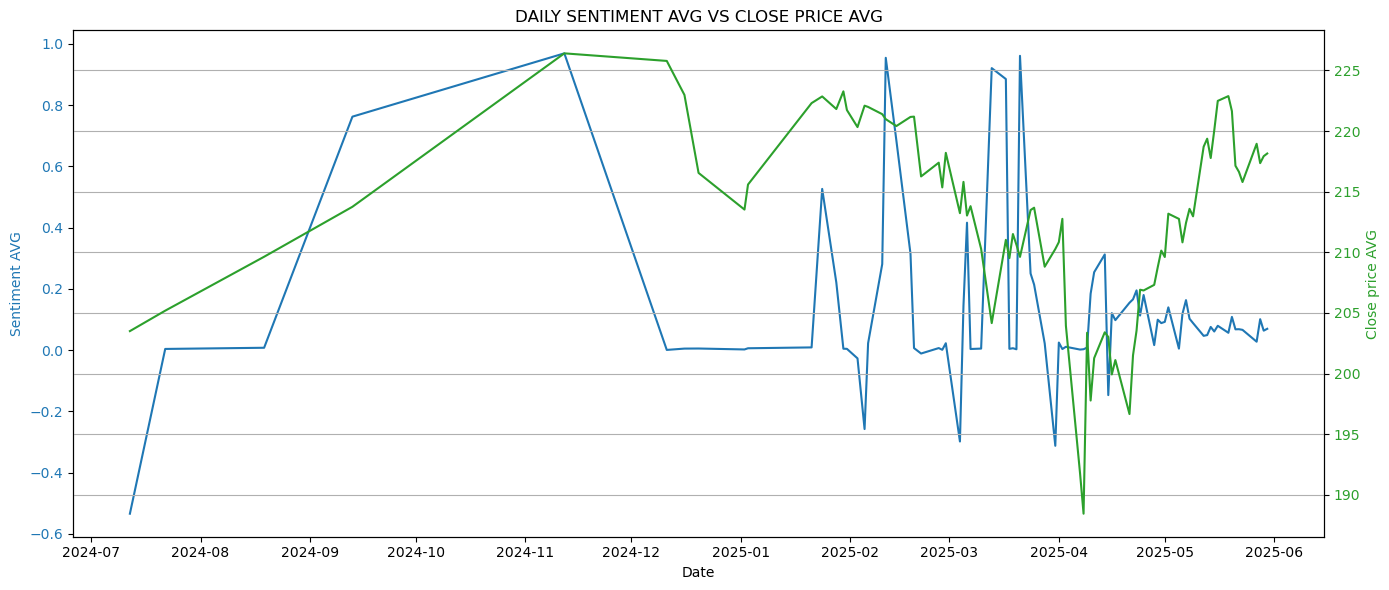

In [12]:
# GROUP BY PUCLICATION DATE
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
df_daily_sentiment = df_news.groupby('PUBLICATION_DATE')['SENTIMENT'].mean().reset_index()
df_daily_sentiment.columns = ['DATE', 'AVG_SENTIMENT']

# DOWNLOAD CLOSE PRICES
tickers = df_meta['TICKER'].unique().tolist()
data = yf.download(tickers, start=str(df_daily_sentiment['DATE'].min()), end=str(df_daily_sentiment['DATE'].max() + pd.Timedelta(days=1))) 
df_close = data['Close']

if df_close.empty:
    raise ValueError("COULDN´T DOWNLOAD THE CLOSE PRICES DATA, VERIFY THE TICKER.")

# DAYLI AVERAGE CLOSE PRICE
df_close_mean = df_close.mean(axis=1).reset_index()
df_close_mean.columns = ['DATE', 'AVG_CLOSE']
df_close_mean['DATE'] = pd.to_datetime(df_close_mean['DATE']).dt.date
df_merged = pd.merge(df_daily_sentiment, df_close_mean, on='DATE', how='inner')

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment AVG', color='tab:blue')
ax1.plot(df_merged['DATE'], df_merged['AVG_SENTIMENT'], color='tab:blue', label='Sentiment AVG')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Close price AVG', color='tab:green')
ax2.plot(df_merged['DATE'], df_merged['AVG_CLOSE'], color='tab:green', label='Close price AVG')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('DAILY SENTIMENT AVG VS CLOSE PRICE AVG')
plt.grid(True)
fig.tight_layout()
plt.show()

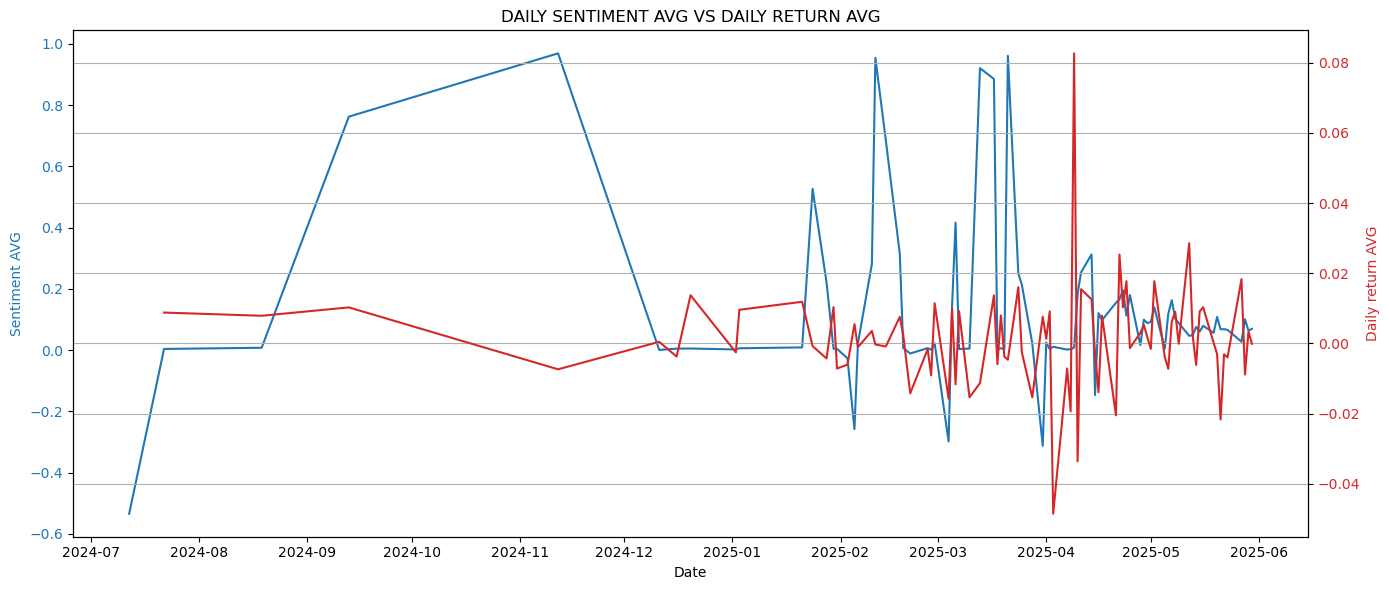

In [13]:
# DAILY RETURNS
df_returns = df_close.pct_change()
df_daily_returns = df_returns.mean(axis=1).reset_index()
df_daily_returns.columns = ['DATE', 'AVG_RETURN']
df_daily_returns['DATE'] = pd.to_datetime(df_daily_returns['DATE']).dt.date

df_compare = pd.merge(df_daily_sentiment, df_daily_returns, on='DATE', how='inner')

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment AVG', color='tab:blue')
ax1.plot(df_compare['DATE'], df_compare['AVG_SENTIMENT'], color='tab:blue', label='Sentiment AVG')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Daily return AVG', color='tab:red')
ax2.plot(df_compare['DATE'], df_compare['AVG_RETURN'], color='tab:red', label='Daily return AVG')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('DAILY SENTIMENT AVG VS DAILY RETURN AVG')
plt.grid(True)
fig.tight_layout()
plt.show()

## Compare Daily Portfolio Value Against Daily Average Sentiment

In this section, you will simulate a simple market portfolio and explore how its performance aligns with daily sentiment scores.

👉 **Instructions**:

1. Simulate a **market portfolio** by computing the cumulative return of the average daily return across all tickers.
2. Start the portfolio with an **initial value of 1.0** and track its value over time.
3. Plot the **daily average sentiment** and the **portfolio value** using a dual-axis line chart.

✅ This visualization lets you explore whether market sentiment leads or lags behind portfolio movements.

> ℹ️ Think about how this setup could inform a basic trading strategy—or whether sentiment could serve as a timing signal.


C:\Users\esteb\AppData\Local\Temp\ipykernel_32632\1630299328.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=str(df_daily_sentiment['DATE'].min()),
[*********************100%***********************]  490 of 490 completed


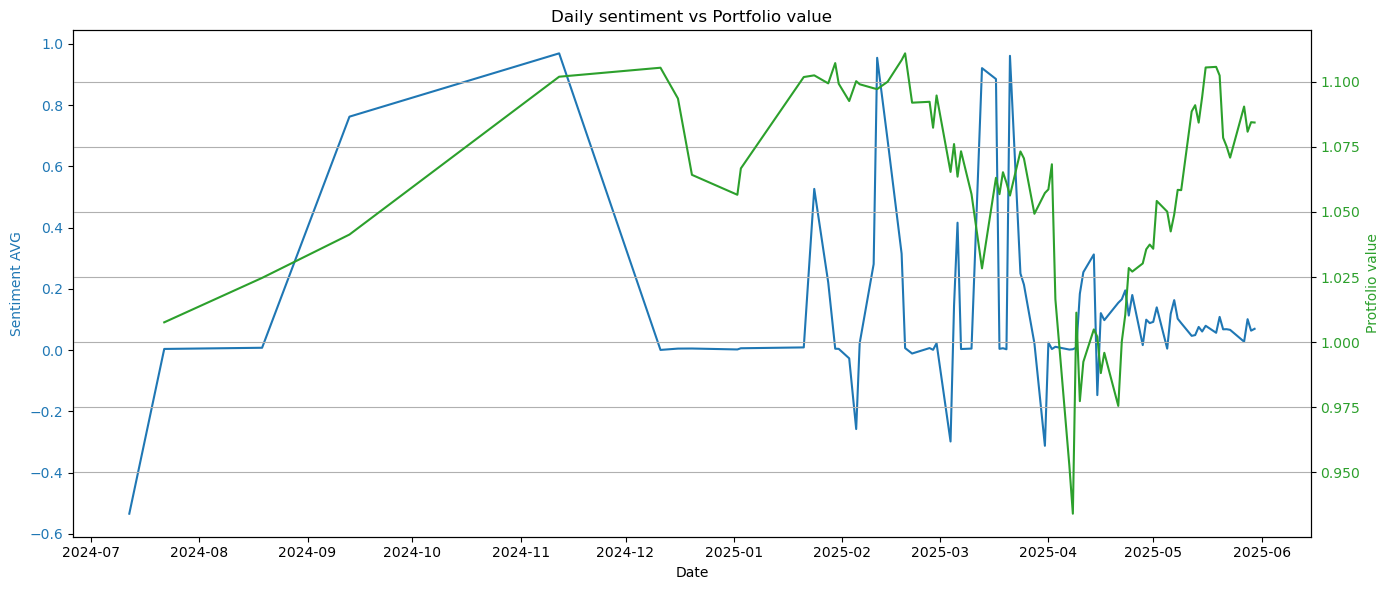

In [14]:

tickers = df_meta['TICKER'].unique().tolist()
data = yf.download(tickers, start=str(df_daily_sentiment['DATE'].min()), 
                   end=str(df_daily_sentiment['DATE'].max() + pd.Timedelta(days=1)))
df_close = data['Close']
df_returns = df_close.pct_change()

# Retorno promedio diario (proxy de mercado)
df_daily_returns = df_returns.mean(axis=1).reset_index()
df_daily_returns.columns = ['DATE', 'AVG_RETURN']
df_daily_returns['DATE'] = pd.to_datetime(df_daily_returns['DATE']).dt.date

# INITIALIZE PORTFOLIO
initial_value = 1.0
df_daily_returns['PORTFOLIO_VALUE'] = (1 + df_daily_returns['AVG_RETURN']).cumprod() * initial_value
df_compare = pd.merge(df_daily_sentiment, df_daily_returns[['DATE', 'PORTFOLIO_VALUE']], on='DATE', how='inner')

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment AVG', color='tab:blue')
ax1.plot(df_compare['DATE'], df_compare['AVG_SENTIMENT'], color='tab:blue', label='Sentiment AVG')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Protfolio value', color='tab:green')
ax2.plot(df_compare['DATE'], df_compare['PORTFOLIO_VALUE'], color='tab:green', label='Porfolio')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('Daily sentiment vs Portfolio value')
plt.grid(True)
fig.tight_layout()
plt.show()

In [15]:
display(df_daily_returns)

,DATE,AVG_RETURN,PORTFOLIO_VALUE
0,2024-07-12,NaN,NaN
1,2024-07-15,0.001197,1.001197
2,2024-07-16,0.016973,1.018191
3,2024-07-17,-0.004495,1.013614
4,2024-07-18,-0.008657,1.004839
...,...,...,...
217,2025-05-23,-0.003979,1.070879
218,2025-05-27,0.018334,1.090512
219,2025-05-28,-0.008875,1.080833
220,2025-05-29,0.003381,1.084487


## Compute Sector-Level Sentiment and Returns

In this section, you’ll analyze how sector-level news sentiment compares to market performance for May. You’ll also measure whether sentiment correlates with returns.

👉 **Instructions**:

1. Group companies by **sector** using the metadata.
2. For each sector:

   * Compute **monthly average sentiment** (Feb to May).
   * (Optional) Count the number of headlines per month.
3. Compute **monthly stock returns** from price data and extract **May returns**.
4. Build a comparison table with:

   * `SECTOR`
   * `SENTIMENT` (May sentiment)
   * `RETURN` (May return)
5. Compute and print the **correlation** between May sentiment and May returns.

✅ This step helps evaluate whether optimistic news coverage for a sector is associated with better performance.

> 💡 Once your analysis is complete, consider:
>
> * Which sectors *looked* good in the news but didn’t perform?
> * Which sectors performed well despite neutral/negative sentiment?
> * Would you invest based on sentiment alone? Why or why not?



In [17]:
#COMPUTE MONTHLY AVERAGE SENTIMENT 

df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE'])

df_sector_news = pd.merge(df_news, df_meta[['TICKER', 'SECTOR']], on='TICKER', how='left')
df_sector_news['MONTH'] = df_sector_news['PUBLICATION_DATE'].dt.to_period('M')

# Mensual sentimen (by sector)
sector_sentiment = df_sector_news.groupby(['SECTOR', 'MONTH'])['SENTIMENT'].mean().reset_index()
sector_sentiment = sector_sentiment[sector_sentiment['MONTH'] == '2025-05']  # Filtro solo mayo
sector_sentiment.rename(columns={'SENTIMENT': 'MAY_SENTIMENT'}, inplace=True)
tickers = df_meta['TICKER'].unique().tolist()
df_prices = yf.download(tickers, start='2025-02-01', end='2025-06-01')['Close']

monthly_close = df_prices.resample('M').last()

# Mensual returns
monthly_returns = monthly_close.pct_change().reset_index()
monthly_returns['MONTH'] = monthly_returns['Date'].dt.to_period('M')
monthly_returns.drop(columns='Date', inplace=True)

returns_long = monthly_returns.melt(id_vars='MONTH', var_name='TICKER', value_name='RETURN')
returns_may = returns_long[returns_long['MONTH'] == '2025-05']

returns_may = pd.merge(returns_may, df_meta[['TICKER', 'SECTOR']], on='TICKER', how='left')

# Return AVG (by sector) may 
sector_returns = returns_may.groupby('SECTOR')['RETURN'].mean().reset_index()
sector_returns.rename(columns={'RETURN': 'MAY_RETURN'}, inplace=True)


sector_comparison = pd.merge(sector_sentiment, sector_returns, on='SECTOR', how='inner')
display(sector_comparison)

correlation = sector_comparison['MAY_SENTIMENT'].corr(sector_comparison['MAY_RETURN'])
print(f" Correlation  Sentiment-Return (may 2025): {correlation:.4f}")

C:\Users\esteb\AppData\Local\Temp\ipykernel_32632\2896273804.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_prices = yf.download(tickers, start='2025-02-01', end='2025-06-01')['Close']
[*********************100%***********************]  490 of 490 completed
C:\Users\esteb\AppData\Local\Temp\ipykernel_32632\2896273804.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_close = df_prices.resample('M').last()


,SECTOR,MONTH,MAY_SENTIMENT,MAY_RETURN
0,Basic Materials,2025-05,0.096240,0.029613
1,Communication Services,2025-05,0.048675,0.043514
2,Consumer Cyclical,2025-05,0.077503,0.056382
3,Consumer Defensive,2025-05,0.060898,0.000008
4,Energy,2025-05,0.031977,0.029434
5,Financial Services,2025-05,0.084058,0.061068
6,Healthcare,2025-05,0.090061,0.000100
7,Industrials,2025-05,0.051870,0.074589
8,Real Estate,2025-05,0.098691,0.010360
9,Technology,2025-05,0.091304,0.075285


 Correlation  Sentiment-Return (may 2025): -0.1178


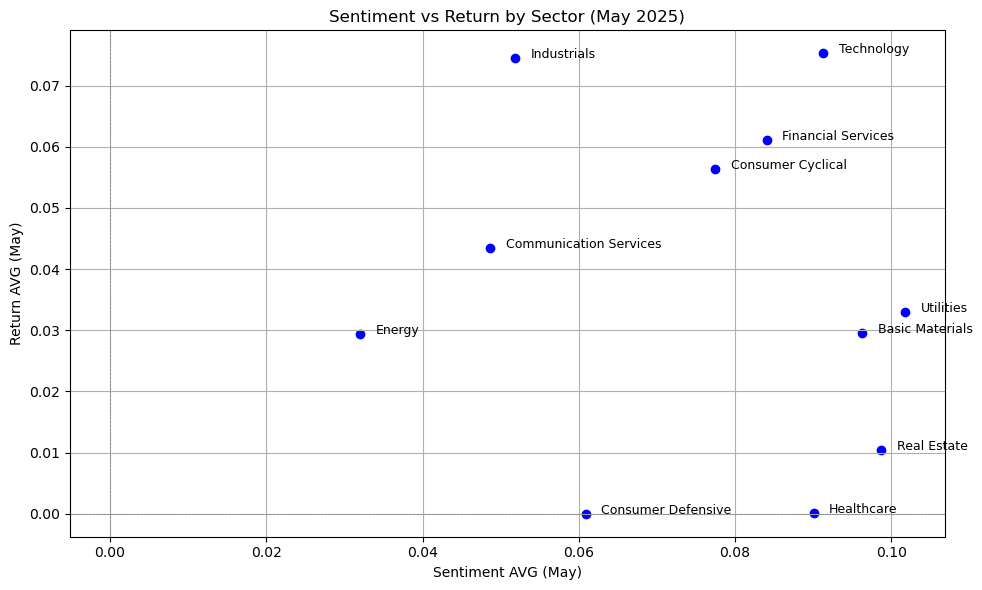

In [19]:

plt.figure(figsize=(10, 6))
plt.scatter(sector_comparison['MAY_SENTIMENT'], sector_comparison['MAY_RETURN'], color='blue')


for i in range(sector_comparison.shape[0]):
    sector = sector_comparison.iloc[i]
    plt.text(sector['MAY_SENTIMENT'] + 0.002, sector['MAY_RETURN'], sector['SECTOR'], fontsize=9)


plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

plt.title("Sentiment vs Return by Sector (May 2025)")
plt.xlabel("Sentiment AVG (May)")
plt.ylabel("Return AVG (May)")
plt.grid(True)
plt.tight_layout()
plt.show()

### **Question 1.** Which sectors *looked* good in the news? How did they perform?


_According to the calculated sentiment, Utilities, Real Estate, Basic Materials, Technology and Healtcare look great on the news, of these 5, Real Estatte and Healtcare were the underperforming sectors._

### **Question 2.** Which sectors performed well despite neutral/negative sentiment?


_The communication services and the Industrials sector, performed well, despite the neutral/negative sentiment, the communications services get a sentiment below the AVG, of 0.0487 and have a return above the AVG of 0.0435, the industrials get a sentiment of 0.0519 and a return of 0.0746_

### **Question 3.**  Would you invest based on sentiment alone? Why or why not?

_Short answer no, made investments desicion based solely on sentiment analysis its risky, also the market sometimes behave in diferent ways, its important to analize the technical infomations, however, sentiment analysis it's an important tool to get a big picture of the forces and events wich could impact different securities_


### **Question 4.**  How would you go about testing a sentiment analysis strategy in a more robust way?

_From a data perspective we can make aditional comparissons, as well as to analyze other indicators, we could  check the distribution of sentiment scores, check the volatility and the trading volume, in oher hand we could improve the system by analiziing the media outlets from wich the news are sourced_
